In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

from astropy.table import Table as ApTable
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

import scarlet

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("scarlet")
dlogger.setLevel(logging.INFO)

[[ 4.24264069  3.60555128  3.16227766  3.          3.16227766  3.60555128
   4.24264069]
 [ 3.60555128  2.82842712  2.23606798  2.          2.23606798  2.82842712
   3.60555128]
 [ 3.16227766  2.23606798  1.41421356  1.          1.41421356  2.23606798
   3.16227766]
 [ 3.          2.          1.          0.          1.          2.          3.        ]
 [ 3.16227766  2.23606798  1.41421356  1.          1.41421356  2.23606798
   3.16227766]
 [ 3.60555128  2.82842712  2.23606798  2.          2.23606798  2.82842712
   3.60555128]
 [ 4.24264069  3.60555128  3.16227766  3.          3.16227766  3.60555128
   4.24264069]]


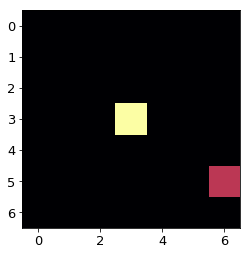

In [341]:
shape = (7,7)
px = 6
py = 5

img = np.zeros(shape)
# Peak
cx = shape[1]//2
cy = shape[0]//2
img[cy,cx] = 1
# Pixel
img[py,px] = .5
# Neighbor
x = np.arange(shape[1])
y = np.arange(shape[0])
X,Y = np.meshgrid(x,y)
X = X-cx
Y = Y-cy
r = np.sqrt(X**2+Y**2)
print(r)

plt.imshow(img)

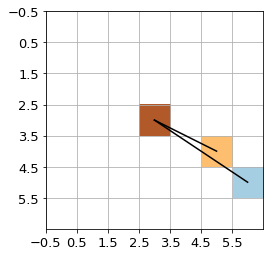

In [355]:
from scarlet.transformations import getRadialMonotonicOp, getSymmetryOp, GammaOp
mono = getRadialMonotonicOp(shape, useNearest=True).toarray()
img = np.zeros((shape[0]*shape[1]))
# Peak
cx = shape[1]//2
cy = shape[0]//2
coord = cy*shape[1] + cx
img[coord] = 1
# Pixel
coord = py*shape[1] + px
img[coord] = .5
# Reference Pixel
ref_coord = np.where(mono[coord]>0)[0][0]
ry = ref_coord//shape[1]
rx = ref_coord-ry*shape[1]
img[ref_coord] = .75
img = np.ma.array(img, mask=img==0)
plt.imshow(img.reshape(shape), cmap='Paired')
plt.plot([cx,px],[cy,py], 'k')
plt.plot([cx,rx],[cy,ry], 'k')
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 6, 1))
ax.set_yticks(np.arange(-.5, 6, 1))
#ax.set_xticklabels(np.arange(1, 12, 1))
#ax.set_yticklabels(np.arange(1, 12, 1))
plt.grid()

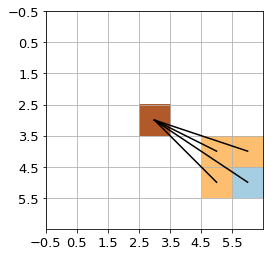

In [354]:
from scarlet.transformations import getRadialMonotonicOp, getSymmetryOp, GammaOp
mono = getRadialMonotonicOp(shape, useNearest=False).toarray()
img = np.zeros((shape[0]*shape[1]))
# Peak
cx = shape[1]//2
cy = shape[0]//2
coord = cy*shape[1] + cx
img[coord] = 1
# Pixel
coord = py*shape[1] + px
img[coord] = .5
# Reference Pixel
ref_coords = np.where(mono[coord]>0)[0]
for ref_coord in ref_coords:
    ry = ref_coord//shape[1]
    rx = ref_coord-ry*shape[1]
    img[ref_coord] = .75

img = np.ma.array(img, mask=img==0)
plt.imshow(img.reshape(shape), cmap='Paired')
plt.plot([cx,px],[cy,py], 'k')
for ref_coord in ref_coords:
    ry = ref_coord//shape[1]
    rx = ref_coord-ry*shape[1]
    plt.plot([cx,rx],[cy,ry], 'k')
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 6, 1))
ax.set_yticks(np.arange(-.5, 6, 1))
#ax.set_xticklabels(np.arange(1, 12, 1))
#ax.set_yticklabels(np.arange(1, 12, 1))
plt.grid()

In [349]:
np.where(mono[coord]>0)[0]

array([33, 34, 40])

In [358]:
idx = 0
#datapath = '/Users/fred/lsst/code/testdata_deblender/sim_data/psf_matched_sim'
#datapath = "/Users/fred/lsst/code/scarlet_paper/two_matched"
datapath = "/Users/fred/lsst/code/scarlet_paper/single_matched"
data = np.load(os.path.join(datapath, 'images_{0}.npz'.format(idx)))
img = data["images"]
filters = data["filters"]
psfs = np.load(os.path.join(datapath, "psfs.npz"))["psfs"]
catalog = ApTable.read(os.path.join(datapath, "true_catalog_{0}.fits".format(idx)))
#coords = np.unique(catalog['y','x'])
coords = catalog['y','x']

In [359]:
import imp
imp.reload(scarlet)
imp.reload(scarlet.source)
imp.reload(scarlet.blend)
imp.reload(scarlet.operators)
imp.reload(scarlet.transformations)
imp.reload(scarlet)

<module 'scarlet' from '/Users/fred/lsst/code/scarlet/scarlet/__init__.py'>

In [378]:
from scarlet.source import init_peak, init_templates
from functools import partial

bg_rms = [10 for _img in img]
#constraints = {"S": None, "m": {'use_nearest': False}, "+":None}
constraints = {"S": None, "+":None, "m": {'use_nearest': False}}
init_shape = (img.shape[0],)+(15,15)
init_func = partial(init_templates, monotonic=True, thresh=0)
#init_func = init_peak
sources = [scarlet.source.Source((coord["y"],coord["x"]), init_shape, constraints=constraints, K=1, shift_center=.2, init_func=init_func) for coord in coords]
print(sources[0].center)
blend = scarlet.blend.Blend(sources, img, bg_rms=bg_rms)
#blend.fit(200)

[ 31.28712746  21.58136599]


INFO:proxmin:Completed 2 iterations
INFO:proxmin:Completed 11 iterations
INFO:proxmin:Completed 41 iterations
INFO:scarlet.blend:No flux in 0, skipping recentering in it 70
INFO:scarlet.blend:No flux in 0, skipping recentering in it 80
INFO:scarlet.blend:No flux in 0, skipping recentering in it 90
INFO:scarlet.blend:No flux in 0, skipping recentering in it 100
INFO:scarlet.blend:No flux in 0, skipping recentering in it 110
INFO:scarlet.blend:resizing source 5 from (9,21) to (19,21) at it 120
INFO:scarlet.blend:max height: 99, width:61
INFO:scarlet.blend:No flux in 0, skipping recentering in it 120
INFO:scarlet.blend:No flux in 0, skipping recentering in it 130
INFO:scarlet.blend:No flux in 0, skipping recentering in it 140
INFO:scarlet.blend:No flux in 0, skipping recentering in it 150
INFO:scarlet.blend:No flux in 0, skipping recentering in it 160
INFO:scarlet.blend:No flux in 0, skipping recentering in it 170
INFO:scarlet.blend:No flux in 0, skipping recentering in it 180
INFO:scarle

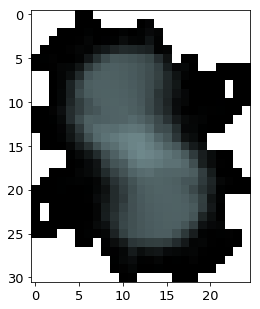

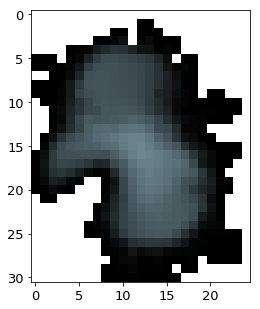

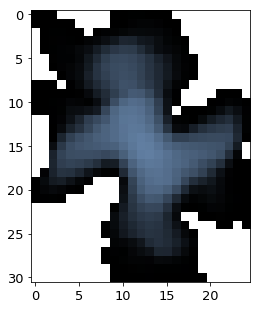

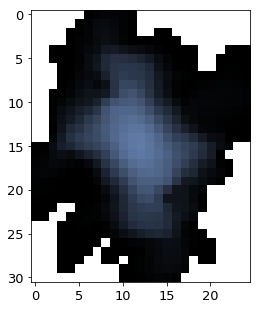

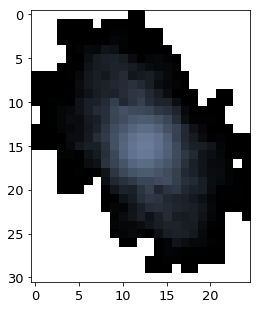

In [379]:
k=3
blend = scarlet.blend.Blend(sources, img, bg_rms=bg_rms)
_model = blend.sources[k].get_model()
display.plotColorImage(images=_model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax)
_m = _model[0]==0
plt.imshow(np.ma.array(_m, mask=_m==0), cmap="Greys")

blend.fit(1)
_model = blend.sources[k].get_model()
display.plotColorImage(images=_model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax)
_m = _model[0]==0
plt.imshow(np.ma.array(_m, mask=_m==0), cmap="Greys")

blend.fit(10)
_model = blend.sources[k].get_model()
display.plotColorImage(images=_model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax)
_m = _model[0]==0
plt.imshow(np.ma.array(_m, mask=_m==0), cmap="Greys")

blend.fit(40)
_model = blend.sources[k].get_model()
display.plotColorImage(images=_model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax)
_m = _model[0]==0
plt.imshow(np.ma.array(_m, mask=_m==0), cmap="Greys")

blend.fit(200)
_model = blend.sources[k].get_model()
display.plotColorImage(images=_model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax)
_m = _model[0]==0
plt.imshow(np.ma.array(_m, mask=_m==0), cmap="Greys")

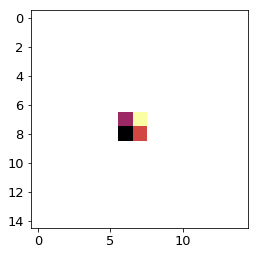

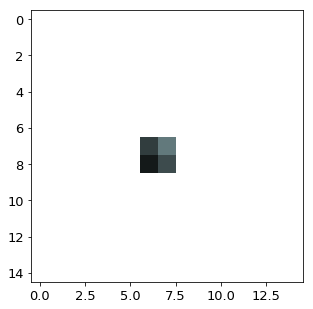

In [361]:
k=3
_model = blend.sources[k].get_model(use_sed=False)[0]
Q=8
z1 = 0
z2 = 100
m = np.arcsinh(Q *(_model - z1)/(z2 - z1))/Q
#_m = display.imagesToRgb(_model, filterIndices=[3,2,1], Q=8, vmin=vmin, vmax=vmax)
plt.imshow(np.ma.array(m, mask=m==0))
#vmin = 0
#vmax = 100
plt.show()
_model = blend.sources[k].get_model()
display.plotColorImage(images=_model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax)
_m = _model[0]==0
plt.imshow(np.ma.array(_m, mask=_m==0), cmap="Greys")

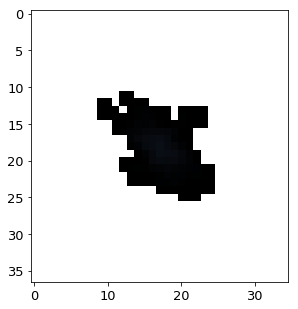

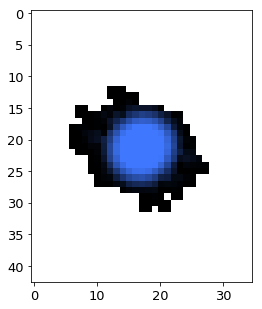

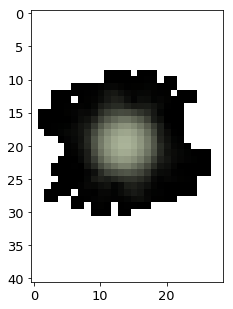

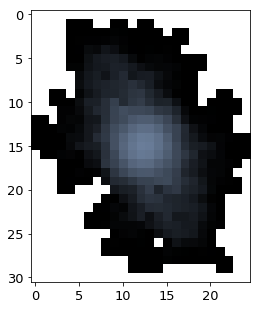

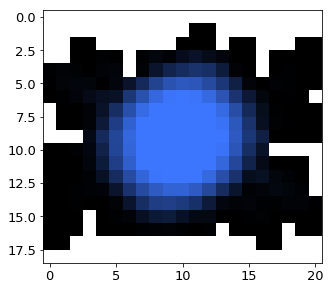

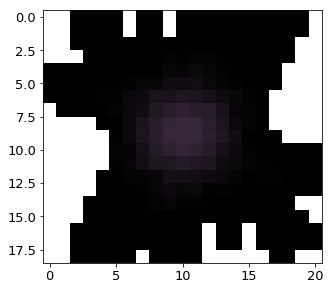

In [337]:
for src in blend.sources:
    model = src.get_model()
    display.plotColorImage(images=model, filterIndices=[3,2,1], Q=8, show=False, vmin=vmin, vmax=vmax)
    _m = model[0]==0
    plt.imshow(np.ma.array(_m, mask=_m==0), cmap="Greys")
    plt.show()

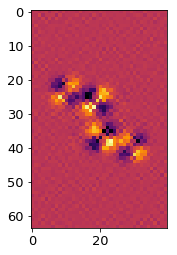

In [68]:
fp = img[0].copy()
sym = getSymmetryOp(fp.shape)
Gamma = GammaOp(fp.shape, offset_int=[py,px])
#Gamma([py, px], fp.shape, )
fp = sym.dot(Gamma([py,px], img.shape).dot(fp.flatten())).reshape(img[0].shape)
plt.imshow(fp)